# Implement Baseline Strategy

In [25]:
# Cell 1: Setup auto-reload
%load_ext autoreload
%autoreload 2

# Cell 2: Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

import core_metrics

In [13]:
def ma_strategy(inv_amt, prices_df, short_ma, long_ma, 
                transaction_costs = 0.001, # as a percent
                slippage = 0.0005 # as a percent
                ):
    # Returns a df with signals, positions, and returns
    df = prices_df.copy()
    df = df.drop(columns=['Dividends', "Capital Gains"], errors="ignore")  

    # calculate moving averages
    df["MA_short"] =  df["Close"].rolling(window = short_ma).mean()
    df["MA_long"] =  df["Close"].rolling(window = long_ma).mean()

    # generate signals
    df["signal"] = 0
    df.loc[df["MA_short"] > df["MA_long"], "signal"] = 1
        # 1 if MA short is above MA long, 0 otherwise

    # identify crossovers
    total_cost = transaction_costs + slippage
    df["position"] = df["signal"].diff()
    df["trade_cost"] = 0.0
    df.loc[df['position'] != 0, 'trade_cost'] = total_cost

    # calculate returns
    df['market_ret'] = df['Close'].pct_change()
    df['strategy_ret'] = df['market_ret'] * df['signal'].shift(1)
    df['strategy_ret_net'] = df['strategy_ret'] - df['trade_cost']
    
    # Market portfolio - buy at beginning, hold for the whole time
    df['market_ret_net'] = df['market_ret'].copy()
    df.loc[df.index[0], 'market_ret_net'] = df.loc[df.index[0], 'market_ret'] - total_cost

    # Calculate cumulative returns
    df['cumulative_market'] = (1 + df['market_ret_net']).cumprod()
    df['cumulative_strategy'] = (1 + df['strategy_ret_net']).cumprod()
    
    # Portfolio value
    df['portfolio_value'] = inv_amt * df['cumulative_strategy']

    df = df.set_index("Date", inplace=False, drop=True, append=False)
    df.index = pd.to_datetime(df.index, utc=True).date

    # df.index = pd.to_datetime(df.index)
    
    return df

In [3]:
# running the strategy
# constants
investment_amount = 10000
test_data = pd.read_csv("../data/processed/training_data_70.csv")
short_ma = 50
long_ma = 200
result = ma_strategy(investment_amount, test_data, short_ma, long_ma)

In [4]:
result.head()

,Open,High,Low,Close,Volume,Stock Splits,MA_short,MA_long,signal,position,trade_cost,market_ret,strategy_ret,strategy_ret_net,market_ret_net,cumulative_market,cumulative_strategy,portfolio_value
2015-01-02,171.378492,171.793694,169.551596,170.589600,121465900,0.0,NaN,NaN,0,NaN,0.0015,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-05,169.543350,169.709428,167.201620,167.508865,169632600,0.0,NaN,NaN,0,0.0,0.0000,-0.018059,-0.0,-0.0,-0.018059,0.981941,1.0,10000.0
2015-01-06,167.816035,168.339192,165.133838,165.931030,209151400,0.0,NaN,NaN,0,0.0,0.0000,-0.009419,-0.0,-0.0,-0.009419,0.972691,1.0,10000.0
2015-01-07,167.259706,168.339232,166.811294,167.998764,125346700,0.0,NaN,NaN,0,0.0,0.0000,0.012461,0.0,0.0,0.012461,0.984812,1.0,10000.0
2015-01-08,169.410413,171.195786,169.393814,170.979874,147217800,0.0,NaN,NaN,0,0.0,0.0000,0.017745,0.0,0.0,0.017745,1.002288,1.0,10000.0


## Core Performance Metrics
To evaluate the basline strategy, we will perform the following tests.


### 1. Profit & Loss Metrics
We've already seen that the strategy returned 58.33% while market returned 123.66% over the same period. Let's examine their annaulized return and their P&L curves.

Final portfolio value: 15833.472027240416 on 2022-09-08 00:00:00
Strategy returned 58.33472027240416% from 2015-01-02 00:00:00 to 2022-09-08 00:00:00
Market returned 123.66242209135079 from 2015-01-02 00:00:00 to 2022-09-08 00:00:00

Annualized across 7.6824 years: 
MA Strategy returned 6.1643% per year
Buy & Hold the market returned 11.0467% per year


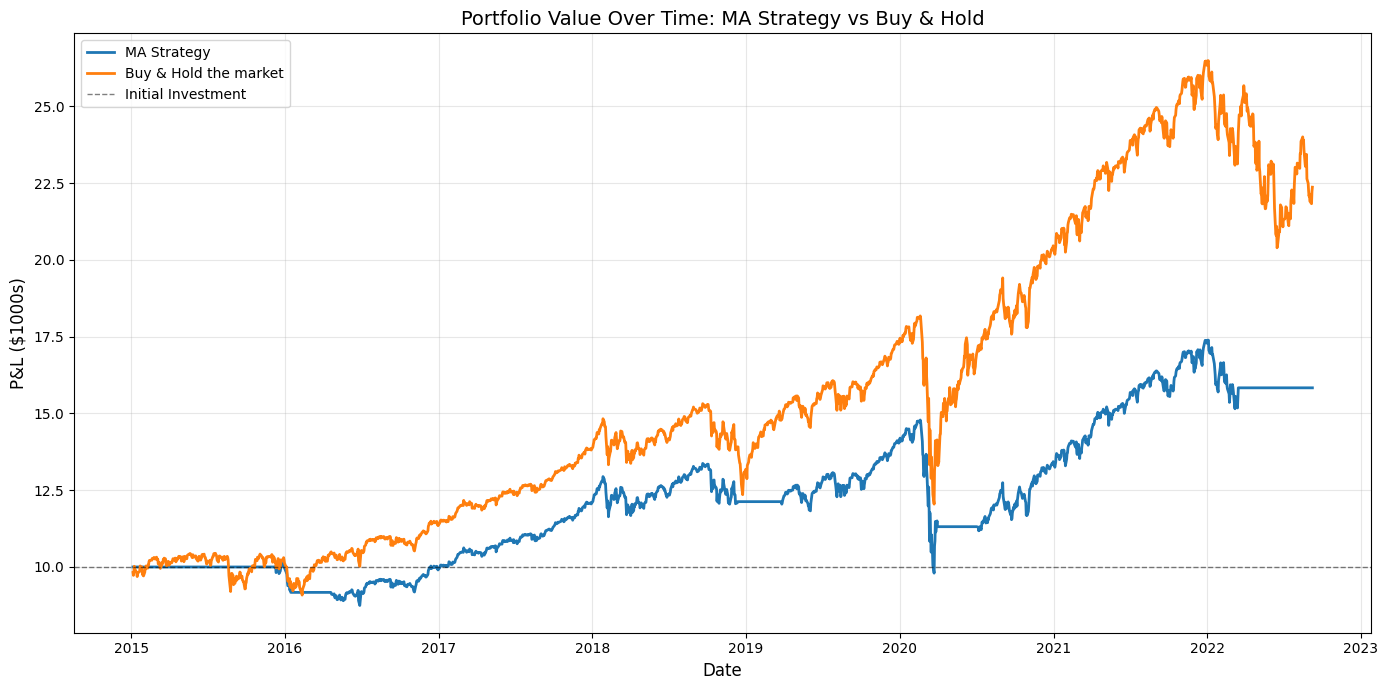

In [6]:
from core_metrics import pnl

graph_title = 'Portfolio Value Over Time: MA Strategy vs Buy & Hold'
strategy_name = "MA Strategy"
benchmark_name = "Buy & Hold the market"

result, strategy_annual_return, market_annual_return = pnl(result, investment_amount, strategy_name, benchmark_name, graph_title)

### 2. Performance Ratios

In [7]:
from core_metrics import performance_ratios

perf_ratios = performance_ratios(result)

print("WITHOUT transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe ratio']}")
print(f"Information Ratio: {perf_ratios['information ratio']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio']} \n")

print("WITH transaction costs...")
print(f"Sharpe Ratio: {perf_ratios['sharpe with costs']}")
print(f"Information Ratios: {perf_ratios['information ratio with costs']}")
print(f"Sortino Ratio: {perf_ratios['sortino ratio with costs']}")


WITHOUT transaction costs...
Sharpe Ratio: 0.29379138411650096
Information Ratio: 6.7953232209499514
Sortino Ratio: 8.7449695125818 

WITH transaction costs...
Sharpe Ratio: 0.28244633987531814
Information Ratios: 6.794253707552498
Sortino Ratio: 8.40084517698903


In [8]:
from core_metrics import risk_metrics

risks = risk_metrics(result)
print(f"Max Drawdown: {(100 * risks['max_drawdown']):.2f}%")
print(f"Average Drawdown: {(100 * risks['avg_drawdown']):.2f}%")
print(f"Max Drawdown Duration: {(risks['max_dd_duration']):.2f} days")
print(f"Average Drawdown Duration: {(risks['avg_dd_duration']):.2f} days")
print(f"Volatility: {(100 * risks['volatility']):.2f}%")

Max Drawdown: -33.72%
Average Drawdown: -5.56%
Max Drawdown Duration: 286.00 days
Average Drawdown Duration: 18.34 days
Volatility: 14.72%


### 4. Trade Statistics

In [9]:
from core_metrics import trade_statistics

trade_stats = trade_statistics(result)
print(f"Total Number of Trades: {trade_stats['num_trades']}")
print(f"Average Holding Periods: {trade_stats['avg_holding_period']}")
print(f"Win Rate: {trade_stats['win_rate']}")
print(f"Win-Loss Ratio: {trade_stats['win_loss_ratio']}")
print(f"Profit Factor (gross profit/gross loss): {trade_stats['profit_factor']}")


Total Number of Trades: 8
Average Holding Periods: 498.0
Win Rate: 0.5
Win-Loss Ratio: inf
Profit Factor (gross profit/gross loss): 5.057422693320084


### 5. Strategy Beta to Benchmark

In [10]:
from core_metrics import find_alpha, calmar_ratio, find_beta

beta = find_beta(result, result.index[0], result.index[-1])
print(f'Beta: {beta}')
alpha = find_alpha(result, strategy_annual_return, market_annual_return)
print(f'Alpha: {alpha}')
calmar = calmar_ratio(strategy_annual_return, risks['max_drawdown'])
print(f'Calmar Ratio: {calmar:.2f}')

Beta: 0.6461615201051376
Alpha: -0.01683890224617969
Calmar Ratio: 0.18


### 5. Consistency of Returns

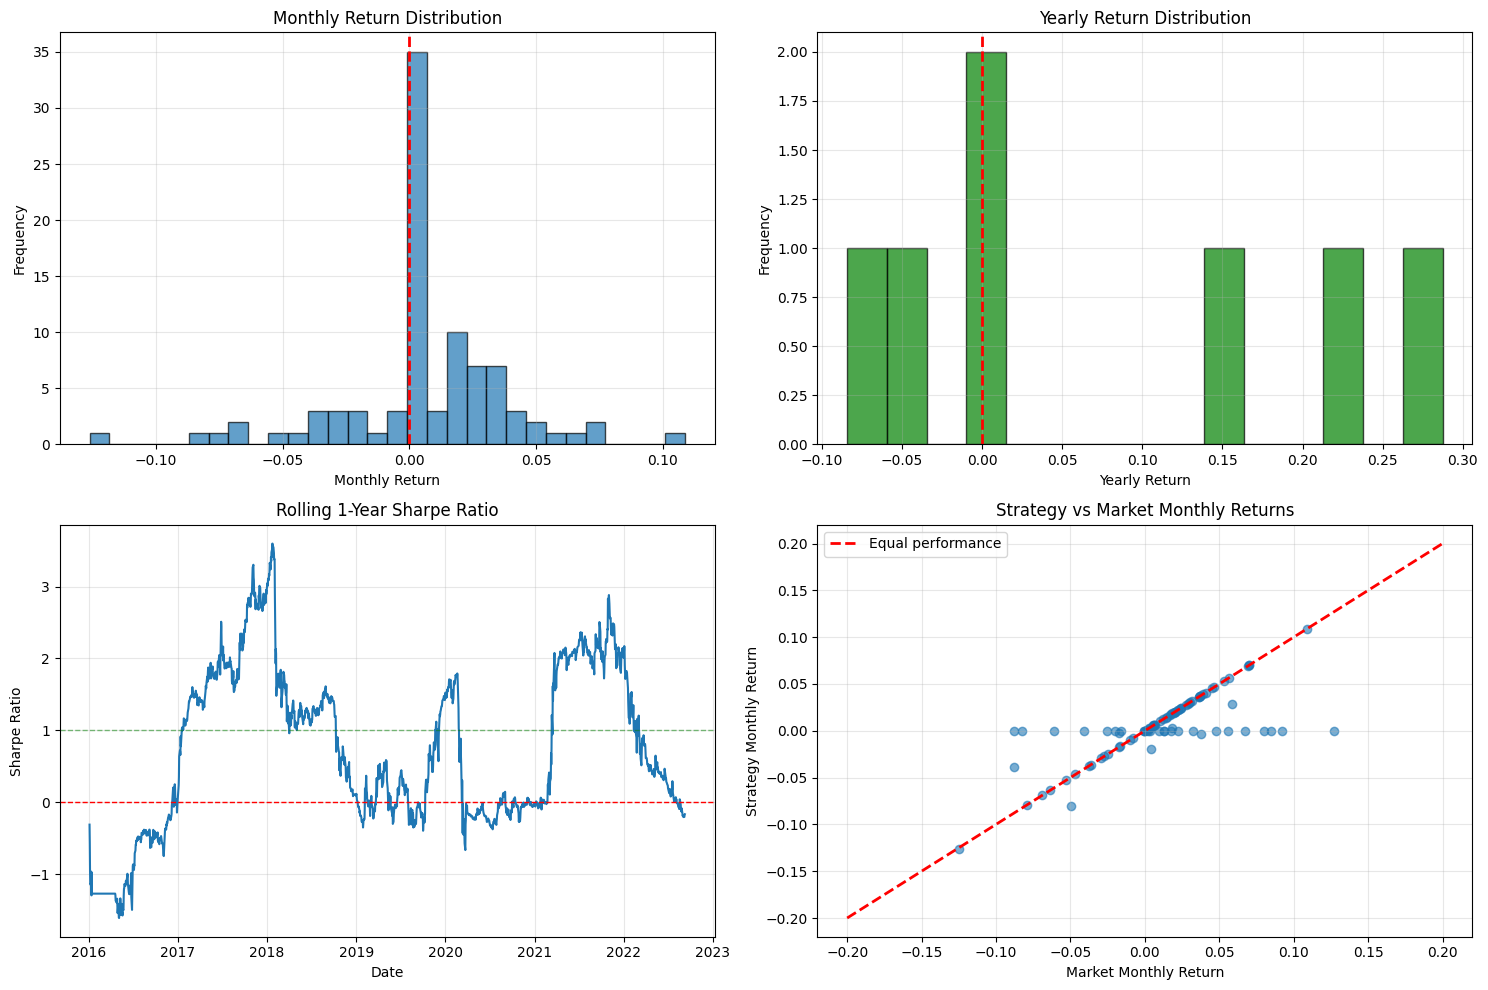

Percentage of Positive Months: 51.61%
Average Monthly Return: 0.56%
Median Monthly Return: 0.12%
Standard Deviation of Monthly Returns: 3.40%
Percentage of Positive Years: 50.00%
Average Yearly Return: 7.63%
Median Yearly Return: 0.63%


In [11]:
from core_metrics import consistency

window = 252 # trading days (for rolling sharpe)
consistency = consistency(result, window)

print(f"Percentage of Positive Months: {consistency['pct_positive_months']:.2%}")
print(f"Average Monthly Return: {consistency['avg_monthly_return']:.2%}")
print(f"Median Monthly Return: {consistency['median_monthly_return']:.2%}")
print(f"Standard Deviation of Monthly Returns: {consistency['std_monthly_return']:.2%}")

print(f"Percentage of Positive Years: {consistency['pct_positive_years']:.2%}")
print(f"Average Yearly Return: {consistency['avg_yearly_return']:.2%}")
print(f"Median Yearly Return: {consistency['median_yearly_return']:.2%}")


### 6. Sensitivity of Returns to Transaction Costs

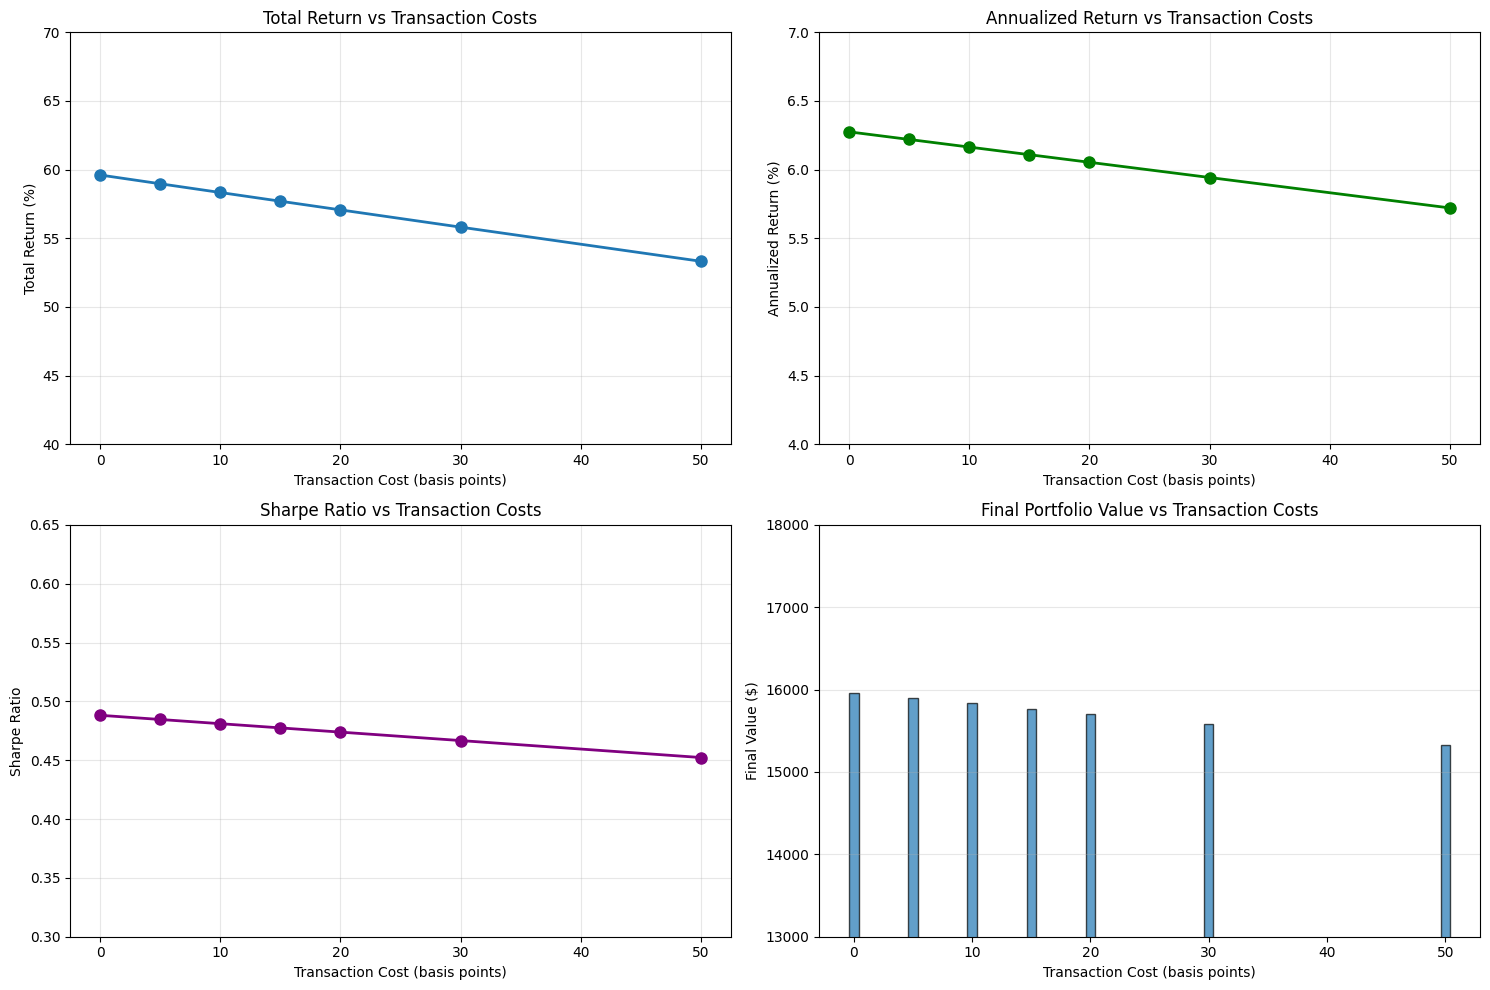

Transaction Cost Sensitivity Analysis
 cost_bps  cost_pct  total_return  annualized_return  sharpe_ratio  final_value
      0.0      0.00      0.596094           0.062751      0.488171 15960.941426
      5.0      0.05      0.589709           0.062197      0.484604 15897.094937
     10.0      0.10      0.583347           0.061643      0.481032 15833.472027
     15.0      0.15      0.577007           0.061088      0.477454 15770.072025
     20.0      0.20      0.570689           0.060534      0.473872 15706.894261
     30.0      0.30      0.558120           0.059425      0.466691 15581.202778
     50.0      0.50      0.533246           0.057208      0.452275 15332.457387


Strategy remains profitable at all tested cost levels


In [37]:
from core_metrics import sensitivity

prices_data = pd.read_csv("../data/processed/training_data_70.csv")
df = sensitivity(ma_strategy, investment_amount, prices_data, short_ma, long_ma)



To do
- do whatever is in file 1 on market data as well to prevent numerous yfinance calls
- debug the last two functions
- start refinements on the strategy
